<a href="https://colab.research.google.com/github/tennissta99660/LLM_project/blob/main/LLM_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 1, ch1-5.
This project involves training a small-scale GPT-style Transformer model (specifically, GPT_CONFIG_124M) using PyTorch. The goal is to teach the model to generate coherent text based on a starting prompt using a custom dataset.

github link:-

In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.6 MB/s eta 0:00:00


In [2]:
import os
from importlib.metadata import version
import torch
import torch.nn as nn
print("torch version:", version("torch"))
import tiktoken
print("tiktoken version:", version("tiktoken"))

torch version: 2.5.1+cu124
tiktoken version: 0.9.0


In [3]:

GPT_CONFIG_124M = {
    "vocab_size": 50257,

    "context_length": 1024,

    "emb_dim": 768,

    "n_heads": 12,

    "n_layers": 12,

    "drop_rate": 0.1,

    "qkv_bias": False
}

In [4]:
import urllib.request

file_path_1 = "text_data_1.txt"
url = "https://www.gutenberg.org/cache/epub/1342/pg1342.txt"

if not os.path.exists(file_path_1):
    with urllib.request.urlopen(url) as response:
        text_data_1 = response.read().decode('utf-8')
    with open(file_path_1, "w", encoding="utf-8") as file:
        file.write(text_data_1)
else:
    with open(file_path_1, "r", encoding="utf-8") as file:
        text_data_1 = file.read()


In [5]:
file_path_2 = "text_data_2.txt"
url = "https://www.gutenberg.org/cache/epub/1400/pg1400.txt"

if not os.path.exists(file_path_2):
    with urllib.request.urlopen(url) as response:
        text_data_2 = response.read().decode('utf-8')
    with open(file_path_2, "w", encoding="utf-8") as file:
        file.write(text_data_2)
else:
    with open(file_path_2, "r", encoding="utf-8") as file:
        text_data_2 = file.read()

In [6]:
dataset = text_data_1 + text_data_2
assert(len(dataset) == len(text_data_1) + len(text_data_2))

In [7]:
with open("final_dataset.txt", "w", encoding = "utf-8") as file_1:
    file_1.write(dataset)

In [8]:
with open("final_dataset.txt", "r", encoding = "utf-8") as raw_text:
  raw_text = raw_text.read()

In [9]:
from importlib.metadata import version
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.5.1+cu124
tiktoken version: 0.9.0


In [10]:
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 1762018
Tokens: 480074


In [11]:
train_ratio = 0.90
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads == 0)
        self.d_out = d_out
        self.num_heads = num_heads

        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)

        return context_vec

In [16]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut

        return x

In [17]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [18]:
def generate_text(model, idx, max_new_tokens, context_size, device):
    idx = idx.to(device)
    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [19]:
def text_to_token_ids(text, tokenizer):

    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})

    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):

    flat = token_ids.squeeze(0)

    return tokenizer.decode(flat.tolist())


In [20]:
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):

     def __init__(self, txt, tokenizer, max_length, stride):

         self.input_ids = []
         self.target_ids = []

         token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})
         assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

         for i in range(0, len(token_ids) - max_length, stride):

             input_chunk = token_ids[i:i + max_length]

             target_chunk = token_ids[i + 1: i + max_length + 1]

             self.input_ids.append(torch.tensor(input_chunk))
             self.target_ids.append(torch.tensor(target_chunk))

     def __len__(self):
         return len(self.input_ids)

     def __getitem__(self, idx):
         return self.input_ids[idx], self.target_ids[idx]

In [21]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
 )

    return dataloader

In [22]:
train_loader = create_dataloader_v1(
     train_data,
     batch_size=2,
     max_length=GPT_CONFIG_124M["context_length"],
     stride=GPT_CONFIG_124M["context_length"],
     drop_last=True,
     shuffle=True,
     num_workers=0
)


val_loader = create_dataloader_v1(
     val_data,
     batch_size=2,
     max_length=GPT_CONFIG_124M["context_length"],
     stride=GPT_CONFIG_124M["context_length"],
     drop_last=False,
     shuffle=False,
     num_workers=0
)

In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
     input_batch, target_batch = input_batch.to(device), target_batch.to(device)
     logits = model(input_batch)
     loss = torch.nn.functional.cross_entropy(
         logits.flatten(0, 1), target_batch.flatten()
     )
     return loss

In [24]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
     total_loss = 0
     if len(data_loader) == 0:
         return float("nan")
     elif num_batches is None:
         num_batches = len(data_loader)
     else:
         num_batches = min(num_batches, len(data_loader))
     for i, (input_batch, target_batch) in enumerate(data_loader):
         if i < num_batches:
             loss = calc_loss_batch(
                 input_batch, target_batch, model, device
             )
             total_loss += loss.item()
         else:
             break
     return total_loss / num_batches

In [25]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.021080225989932
Validation loss: 11.02421350064485


In [26]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size, device=device
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [27]:
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.00005, weight_decay=0.02
)
num_epochs = 5

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=10, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.621, Val loss 10.627
Ep 1 (Step 000010): Train loss 9.201, Val loss 9.059
Ep 1 (Step 000020): Train loss 8.412, Val loss 8.477
Ep 1 (Step 000030): Train loss 8.076, Val loss 7.994
Ep 1 (Step 000040): Train loss 7.665, Val loss 7.544
Ep 1 (Step 000050): Train loss 7.315, Val loss 7.156
Ep 1 (Step 000060): Train loss 6.812, Val loss 6.844
Ep 1 (Step 000070): Train loss 6.667, Val loss 6.615
Ep 1 (Step 000080): Train loss 6.209, Val loss 6.427
Ep 1 (Step 000090): Train loss 6.531, Val loss 6.288
Ep 1 (Step 000100): Train loss 6.097, Val loss 6.175
Ep 1 (Step 000110): Train loss 6.169, Val loss 6.101
Ep 1 (Step 000120): Train loss 6.130, Val loss 6.037
Ep 1 (Step 000130): Train loss 5.931, Val loss 5.987
Ep 1 (Step 000140): Train loss 5.929, Val loss 5.938
Ep 1 (Step 000150): Train loss 5.908, Val loss 5.890
Ep 1 (Step 000160): Train loss 5.880, Val loss 5.854
Ep 1 (Step 000170): Train loss 5.848, Val loss 5.827
Ep 1 (Step 000180): Train loss 5.968, Val lo

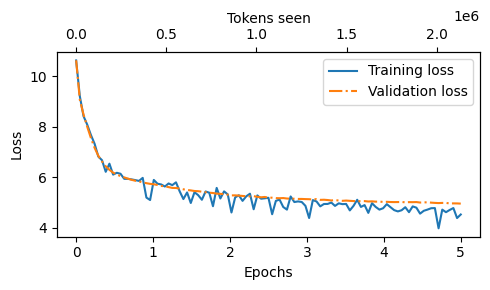

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [29]:
def user_input(context):
  generate_and_print_sample(model, tokenizer, device, context)

In [30]:
context = input("please enter starting context: ")
user_input(context)

please enter starting context: I am a student
I am a student. “I am not.” “I“I” ” “I“I“I“I“I”  “I am “I


In [31]:
torch.save(model.state_dict(), "model.pth")

In [32]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

In [33]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [34]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();